# Randomized Image Sampling for Explanations (RISE)

In [5]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from RISE.rise_utils import *
from RISE.explanations import RISE

cudnn.benchmark = True

In [6]:
args = Dummy()

# Number of workers to load data
args.workers = 8
# Directory with images split into class folders.
# Since we don't use ground truth labels for saliency all images can be 
# moved to one class folder.
args.datadir = 'data/ILSVRC2012_img_val/'
# Sets the range of images to be explained for dataloader.
args.range = range(0, 10)
# Size of imput images.
args.input_size = (224, 224)
# Size of batches for GPU. 
# Use maximum number that the GPU allows.
args.gpu_batch = 250

## Prepare data

In [7]:
#dataset = datasets.ImageFolder(args.datadir, preprocess)

# This example only works with batch size 1. For larger batches see RISEBatch in explanations.py.
data_loader = torch.utils.data.DataLoader(
    args.datadir, batch_size=1, shuffle=False,
    num_workers=args.workers, pin_memory=True, sampler=RangeSampler(args.range))

#print('Found {: >5} images belonging to {} classes.'.format(len(dataset), len(dataset.classes)))
print('      {: >5} images will be explained.'.format(len(data_loader) * data_loader.batch_size))

         10 images will be explained.


## Load black-box model

In [9]:
# Load black box model for explanations
model = models.resnet18(pretrained=True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False
    
# To use multiple GPUs
#model = nn.DataParallel(model)

## Create explainer instance

In [10]:
explainer = RISE(model, args.input_size, args.gpu_batch)

In [11]:
%reload_ext autoreload
%autoreload 2
# Generate masks for RISE or use the saved ones.
maskspath = 'masks.npy'
generate_new = True

if generate_new or not os.path.isfile(maskspath):
    explainer.generate_masks(N=6000, s=8, p1=0.1, savepath=maskspath)
    print("Masks are generated.")
else:
    explainer.load_masks(maskspath)
    print('Masks are loaded.')

Generating filters: 100%|██████████| 6000/6000 [00:17<00:00, 350.49it/s]


Masks are generated.


(375, 500, 3)


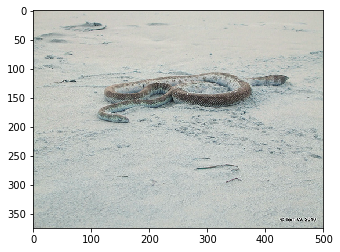

In [15]:
import cv2
img = cv2.imread('/work/lisabdunlap/explain-eval/data/ILSVRC2012_img_val/ILSVRC2012_val_00000001.JPEG')
print(np.array(img).shape)
val_img = cv2.resize(img, (224, 224))
plt.imshow(img)

## Explaining one instance
Producing saliency maps for top $k$ predicted classes.

In [16]:
gen_rise_grounding(read_tensor('/work/lisabdunlap/explain-eval/data/ILSVRC2012_img_val/ILSVRC2012_val_00000001.JPEG'), 'resnet18')

AttributeError: 'str' object has no attribute 'astype'

In [17]:
def example(img, top_k=3):
    saliency = explainer(img).cpu().numpy()
    p, c = torch.topk(model(img), k=top_k)
    p, c = p[0], c[0]
    
    plt.figure(figsize=(10, 5*top_k))
    for k in range(top_k):
        plt.subplot(top_k, 2, 2*k+1)
        plt.axis('off')
        plt.title('{:.2f}% {}'.format(100*p[k], get_class_name(c[k])))
        tensor_imshow(img[0])

        plt.subplot(top_k, 2, 2*k+2)
        plt.axis('off')
        plt.title(get_class_name(c[k]))
        tensor_imshow(img[0])
        sal = saliency[c[k]]
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)

    plt.show()
    return sal

In [19]:
sal = example(read_tensor('/work/lisabdunlap/explain-eval/data/ILSVRC2012_img_val/ILSVRC2012_val_00036091.JPEG'), 1)

AttributeError: 'str' object has no attribute 'astype'

## Explaining all images in dataloader
Explaining the top predicted class for each image.

In [14]:
def explain_all(data_loader, explainer):
    # Get all predicted labels first
    target = np.empty(len(data_loader), np.int)
    for i, (img, _) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Predicting labels')):
        p, c = torch.max(model(img.cuda()), dim=1)
        target[i] = c[0]

    # Get saliency maps for all images in val loader
    explanations = np.empty((len(data_loader), *args.input_size))
    for i, (img, _) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Explaining images')):
        saliency_maps = explainer(img.cuda())
        explanations[i] = saliency_maps[target[i]].cpu().numpy()
    return explanations

In [15]:
explanations = explain_all(data_loader, explainer)

# Save explanations if needed.
# explanations.tofile('exp_{:05}-{:05}.npy'.format(args.range[0], args.range[-1]))

Predicting labels:   0%|          | 0/10 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
for i, (img, _) in enumerate(data_loader):
    p, c = torch.max(model(img.cuda()), dim=1)
    p, c = p[0].item(), c[0].item()
    
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.axis('off')
    plt.title('{:.2f}% {}'.format(100*p, get_class_name(c)))
    tensor_imshow(img[0])
    
    plt.subplot(122)
    plt.axis('off')
    plt.title(get_class_name(c))
    tensor_imshow(img[0])
    sal = explanations[i]
    plt.imshow(sal, cmap='jet', alpha=0.5)
    #plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.show()